In [109]:
import numpy as np
import re
import copy
import string

In [110]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [112]:
with open('test.txt', 'r') as f:
    text = f.read()
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
    print(list(word_tokenize(text)))

['Provide', 'some', 'illustrative', 'examples', 'to', 'your', 'problem', 'formulation', 'and', 'its', 'solution', '.']


In [113]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

import re
import string

from itertools import combinations

In [114]:
class ArticleTokenizer:
    def __init__(self):
        # Download nltk data
        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')
        nltk.download('stopwords')
        nltk.download('wordnet')
        
        self.stopwords = stopwords.words('english')
        self.porter_stemmer = PorterStemmer()

    def extract_words(self, text):
        # Split text using phrase boundaries (except periods)
        phrase_boundaries = [',', '!', '?', ';', ':', '\'', '\"', '(', ')', '[', ']', '{', '}', '<', '>', '-', '\n', '\t']
        split_pattern = '|'.join(re.escape(boundary) for boundary in phrase_boundaries)
        splitted_text = re.split(split_pattern, text)
        splitted_text = [phrase.strip(' ') for phrase in splitted_text if bool(phrase.strip(' '))]

        # Split text by periods while keeping internal periods
        new_splitted_text = []
        for phrase in splitted_text:
            splitted_phrase = phrase.split(' ')
            for word in splitted_phrase:
                # Check if word is at the end of a sentence (last character is a period but no internal period(s))
                if word[-1] == '.' and word.count('.') == 1:
                    if bool(word[:-1]):
                        new_splitted_text.append(word[:-1].strip(' '))
                else :
                    if bool(word):
                        new_splitted_text.append(word.strip(' '))
        splitted_text = new_splitted_text
        return list(word_tokenize(text))
        
    
    # Keyword extraction based on the papers: 
    # Domain-Specific Keyphrase Extraction
    # Improved Automatic Keyword Extraction Given More Linguistic Knowledge
    def extract_keywords(self, text, max_keyword_length=3):
        # Split text using phrase boundaries (except periods)
        phrase_boundaries = [',', '!', '?', ';', ':', '\'', '\"', '(', ')', '[', ']', '{', '}', '<', '>', '-', '\n']
        split_pattern = '|'.join(re.escape(boundary) for boundary in phrase_boundaries)
        splitted_text = re.split(split_pattern, text)
        splitted_text = [phrase.strip() for phrase in splitted_text if bool(phrase.strip())]

        # Split text by periods while keeping internal periods + remove and split text by numbers and stopwords
        new_splitted_text = []
        for phrase in splitted_text:
            splitted_phrase = phrase.split(' ')
            new_phrase = ''
            for word in splitted_phrase:
                # Check if word is at the end of a sentence (last character is a period but no internal period(s))
                if word[-1] == '.' and word.count('.') == 1:
                    new_phrase += f' {word[:-1]}'
                    if bool(new_phrase):
                        new_splitted_text.append(new_phrase)
                    new_phrase = ''
                elif word.isnumeric() or word.lower() in self.stopwords:
                    if bool(new_phrase):
                        new_splitted_text.append(new_phrase)
                    new_phrase = ''
                else :
                    new_phrase += f' {word}'
            if bool(new_phrase):
                new_splitted_text.append(new_phrase)
        splitted_text = new_splitted_text
        splitted_text = [phrase.strip() for phrase in splitted_text]

        # Extract substrings of candidate phrases with 3 or less words + capitalize words
        candidate_phrases = []
        for phrase in splitted_text:
            words = []
            for word in phrase.split(' '):
                if word.isalpha() and not word.isupper() and not word.islower():
                    words.append(word.lower())
                else:
                    words.append(word)
                    
            for i in range(1, max_keyword_length + 1):
                for j in range(len(words) - i + 1):
                    if j - i == 1:
                        candidate_phrases.append(words[j])
                    else: 
                        candidate_phrases.append(' '.join(words[j: j+i]))
        candidate_phrases = set(candidate_phrases)
                
        return [phrase.strip() for phrase in candidate_phrases]

tokenizer = ArticleTokenizer()
keywords = tokenizer.extract_keywords(text, 1)
tagged_keywords = pos_tag(keywords)
words_list = tokenizer.extract_words(text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
tagged_keywords

[('illustrative', 'JJ'),
 ('problem', 'NN'),
 ('solution', 'NN'),
 ('formulation', 'NN'),
 ('examples', 'NNS'),
 ('provide', 'VBP')]

In [116]:
tagged_keywords = [tagged_keyword for tagged_keyword in tagged_keywords if tagged_keyword[1][0] == 'J' or tagged_keyword[1][0] == 'N' or tagged_keyword[1][:2] == 'VB']
tagged_keywords.sort()
tagged_keywords

[('examples', 'NNS'),
 ('formulation', 'NN'),
 ('illustrative', 'JJ'),
 ('problem', 'NN'),
 ('provide', 'VBP'),
 ('solution', 'NN')]

In [127]:
def are_adjacent2(indices_1, indices_2):
    i = 0
    j = 0
    while i < len(indices_1) and j < len(indices_2):
        if indices_2[j] - indices_1[i] == 1:
            return True
        if indices_1[i] == min(indices_1[i], indices_2[j]):
            i += 1
        else:
            j += 1
    return False
    
def are_adjacent3(indices_1, indices_2, indices_3):
    i = 0
    j = 0
    k = 0
    while i < len(indices_1) and j < len(indices_2) and k < len(indices_3):
        if indices_2[j] - indices_1[i] == 1 and indices_3[k] - indices_2[j] == 1:
            return True
        if indices_1[i] == min(indices_1[i], indices_2[j], indices_3[k]):
            i += 1
        elif indices_2[j] == min(indices_1[i], indices_2[j], indices_3[k]):
            j += 1
        else:
            k += 1
    return False

def create_keyword_indices(keywords, words_list):
    keyword_indices = {}
    for keyword in keywords:
        if keyword in keyword_indices:
            keyword_indices[keyword] += [i for i in range(len(words_list)) if words_list[i].lower() == keyword.lower()]
        else:
            keyword_indices[keyword] = [i for i in range(len(words_list)) if words_list[i].lower() == keyword.lower()]
    return keyword_indices

def create_wordgraph(keyword_indices, max_distance=10, directed=False):
    graph_size = len(keyword_indices.keys())
    graph_matrix = np.zeros((graph_size, graph_size))

    for idx_1, keyword_1 in enumerate(keyword_indices.keys()):
        for idx_2, keyword_2 in enumerate(keyword_indices.keys()):
            if keyword_1 == keyword_2:
                continue
            i = 0
            j = 0
            while i < len(keyword_indices[keyword_1]) and j < len(keyword_indices[keyword_2]):
                distance = keyword_indices[keyword_2][j] - keyword_indices[keyword_1][i]
                if distance < max_distance and distance > 0:
                    if not directed:
                        graph_matrix[idx_2][idx_1] = 1
                    graph_matrix[idx_1][idx_2] = 1
                    break
                if keyword_indices[keyword_1][i] > keyword_indices[keyword_2][j]:
                    j += 1
                else:
                    i += 1
    return graph_matrix, list(keyword_indices.keys())

keyword_indices = create_keyword_indices([tagged_keyword[0] for tagged_keyword in tagged_keywords], words_list)
graph_matrix, keywords = create_wordgraph(keyword_indices, max_distance=4, directed=False)

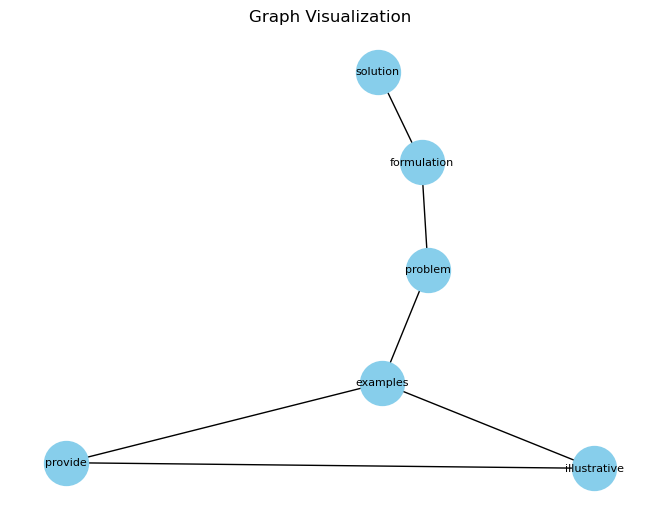

In [128]:
import networkx as nx

def plot_graph(adjacency_matrix, node_names):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(adjacency_matrix))

    # Assign node names
    mapping = {i: node_names[i] for i in range(len(node_names))}
    G = nx.relabel_nodes(G, mapping)

    # Draw the graph
    pos = nx.spring_layout(G)  # or any other layout
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=8, font_weight='normal')
    plt.title("Graph Visualization")
    plt.show()

plot_graph(graph_matrix, keywords)

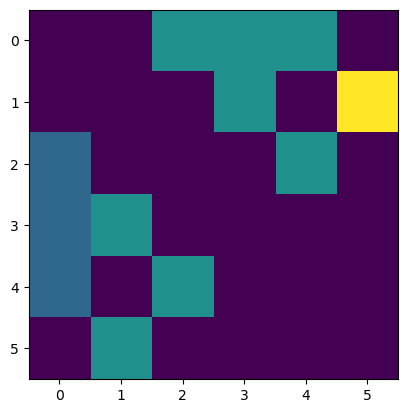

In [129]:
def format_graphmatrix(graph_matrix):
    num_branches = graph_matrix.sum(axis=0)
    page_num = len(num_branches)
    for u in range(page_num):
        for v in range(page_num):
            if num_branches[v] > 0:
                pass
                graph_matrix[u][v] *= 1/num_branches[v]
    return graph_matrix
plt.imshow(format_graphmatrix(graph_matrix))

In [130]:
# Iteratively calculate PageRank scores based on given transition matrix and given params. 
# Returns a list of PageRank scores over the iterations
def calculate_pagerank(trans_mat, damp_factor=0.85, max_iter=2000, threshold=0.0001, use_taxation=True):
    num_pages = trans_mat.shape[0]
    
    # Initialize PageRank scores
    pr_scores = np.ones(num_pages)

    # Create a log list for PageRank scores
    pr_scores_list = [pr_scores]

    # Copy input transition matrix
    matrix = copy.deepcopy(trans_mat)

    # Find and fill deadends as 1 / num_pages to teleport to another node
    no_links_pages = np.where(~matrix.any(axis=0))[0]
    matrix[:, no_links_pages] = 1 / num_pages

    # Iteratively computes new PageRank scores
    for i in range(max_iter):
        new_pr_scores = np.zeros(num_pages)
        
        # Check if taxation is used or not
        if use_taxation:
            new_pr_scores = damp_factor * np.dot(matrix, pr_scores) + (1 - damp_factor) / num_pages * np.ones(num_pages)
        else:
            new_pr_scores = np.dot(matrix, pr_scores)

        # Check if new PageRank score updates are smaller than thereshold
        if np.max(np.abs(new_pr_scores - pr_scores)) < threshold:
            break
        pr_scores = new_pr_scores
        pr_scores_list.append(new_pr_scores)

    return pr_scores_list
textrank_scores = calculate_pagerank(graph_matrix)
np.max(graph_matrix)

1.0

In [123]:
keyword_scores = []
for i in range(len(keywords)):
    keyword_scores.append((textrank_scores[-1][i], keywords[i]))
keyword_scores.sort(reverse=True)
print(keyword_scores)

[(0.28496683786219873, 'provide'), (0.2084497540777554, 'examples'), (0.1682527244790066, 'problem'), (0.1540099246929769, 'illustrative'), (0.12098111207893428, 'formulation'), (0.06538646109087684, 'solution')]


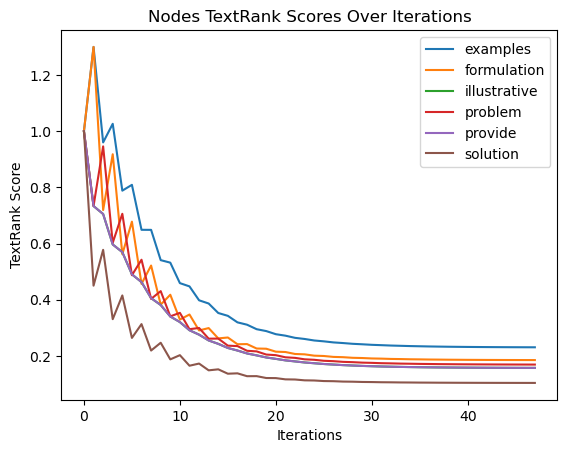

In [131]:
for idx, node_name in enumerate(keywords):
    node_pr_scores = []
    for timeframe in textrank_scores:
        node_pr_scores.append(timeframe[idx])
    plt.plot(node_pr_scores, label=node_name)
plt.title('Nodes TextRank Scores Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('TextRank Score')
plt.legend()
plt.show()

In [135]:
def postprocess_keywords(self, max_accepted_words):
    final_keywords = set()
    self.keyword_scores.sort(reverse=True)
    accepted_keyword_scores = self.keyword_scores[:max_accepted_words]
    for keyword_score_1 in accepted_keyword_scores:
        found_2 = False
        for keyword_score_2 in self.keyword_scores:
            if keyword_score_1 == keyword_score_2:
                continue
            if self.are_adjacent2(self.keyword_indices[keyword_score_1[1]], self.keyword_indices[keyword_score_2[1]]):
                found_2 = True
                found_3 = False
                for keyword_score_3 in self.keyword_scores:
                    if keyword_score_2 == keyword_score_3 or keyword_score_1 == keyword_score_3:
                        continue
                    if self.are_adjacent3(self.keyword_indices[keyword_score_1[1]], self.keyword_indices[keyword_score_2[1]], self.keyword_indices[keyword_score_3[1]]):
                            found_3 = True
                            final_keywords.add(keyword_score_1[1] + ' ' + keyword_score_2[1] + ' ' + keyword_score_3[1])
                if not found_3:
                    final_keywords.add(keyword_score_1[1] + ' ' + keyword_score_2[1])
        if not found_2:
            final_keywords.add(keyword_score_1[1])

                
    return final_keywords

def postprocess_keywords_chronological(self, max_accepted_words, max_keyword_length):
    final_keywords = set()
    self.keyword_scores.sort(reverse=True)
    accepted_keyword_scores = self.keyword_scores[:max_accepted_words]
    accepted_keywords = [accepted_keyword_score[1] for accepted_keyword_score in accepted_keyword_scores]

    scores = {}
    for keyword_score in self.keyword_scores:
        scores[keyword_score[1].lower()] = keyword_score[0]

    idx = 0
    keyword_phrase = ''
    score = 0
    while idx < len(self.words_list):
        word = self.words_list[idx]
        # If current keyword phrase is empty
        if not bool(keyword_phrase):
            if word.lower() in accepted_keywords:
                keyword_phrase = word
        else:
            if word.lower() in self.keywords:
                keyword_phrase += f' {word}'
            else:
                final_keywords.add((scores[keyword_phrase.split(' ')[0].lower()], keyword_phrase))
                keyword_phrase = ''
        if len(keyword_phrase.split(' ')) >= max_keyword_length:
            final_keywords.add((scores[keyword_phrase.split(' ')[0].lower()], keyword_phrase))
            keyword_phrase = ''
        idx += 1
    final_keywords = list(final_keywords)
    final_keywords.sort(reverse=True)
    return [keyword[1] for keyword in final_keywords]

In [141]:
import importlib

import text_rank
importlib.reload(text_rank)

import string

with open('test.txt', 'r') as f:
    text = f.read()
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
    print(text)

tokenizer = text_rank.ArticleTokenizer()
keywords = tokenizer.extract_keywords(text, 1)
tagged_keywords = tokenizer.tag_keywords(keywords)
words_list = tokenizer.extract_words(text)

word_graph = text_rank.WordGraph(keywords, words_list, max_distance=2, directed=True)
word_graph.calculate_pagerank()

final_keywords = [keyword.capitalize() for keyword in word_graph.postprocess_keywords_chronological(3, 3) if bool(keyword)]
print(word_graph.calculate_pagerank())
print(final_keywords)

Provide some illustrative examples to your problem formulation and its solution.
[array([1., 1., 1., 1., 1., 1.]), array([1.44166667, 1.44166667, 0.59166667, 0.59166667, 0.59166667,
       0.59166667]), array([1.10402778, 1.10402778, 0.60111111, 0.60111111, 0.60111111,
       0.60111111]), array([1.01906713, 1.01906713, 0.50812269, 0.50812269, 0.50812269,
       0.50812269]), array([0.88960806, 0.88960806, 0.45770378, 0.45770378, 0.45770378,
       0.45770378]), array([0.79578657, 0.79578657, 0.40673836, 0.40673836, 0.40673836,
       0.40673836]), array([0.711443 , 0.711443 , 0.3657154, 0.3657154, 0.3657154, 0.3657154]), array([0.64105296, 0.64105296, 0.33019488, 0.33019488, 0.33019488,
       0.33019488]), array([0.58085254, 0.58085254, 0.30018689, 0.30018689, 0.30018689,
       0.30018689]), array([0.52978669, 0.52978669, 0.27462784, 0.27462784, 0.27462784,
       0.27462784]), array([0.48635111, 0.48635111, 0.25291745, 0.25291745, 0.25291745,
       0.25291745]), array([0.44943926,

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
